In [3]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import pickle
from keras import layers
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.metrics import precision_recall_curve
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
#package import
rawdata=pd.read_csv('twitter_final_Dataset.csv',low_memory=False)
#data import

In [ ]:
rawdata = rawdata.sample(frac=1).reset_index(drop=True)
split_idx = int(0.8 * len(rawdata))

train = rawdata.iloc[:split_idx]
test = rawdata.iloc[split_idx:]

train.to_csv('training_data.csv', index=False)
test.to_csv('testing_data.csv', index=False)

In [6]:
train=pd.read_csv('/content/training_dataset.csv')
test=pd.read_csv('/content/testing_dataset.csv')
#refining the data
train=train.dropna()
test=test.dropna()

In [8]:
#function to clean data
def cleannuptext(tweet):
  #removes urls
  tweet = re.sub(r'http\S+','',tweet)

  tweet=re.sub(r'@\w+\s','',tweet)
  #remove usernames
  
  tweet = re.sub(r'[^\w\s]','',tweet).lower()
  #remove punctuation and makes it lowercase
    
  tweet = ' '.join([w for w in tweet.split() if len(w)>2])
  #remove words with len less than 2
  
  #tokenize the words
  tokenized_tweet = nltk.word_tokenize(tweet)
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tweet = ' '.join([lemmatizer.lemmatize(w) for w in tokenized_tweet])
  return tweet

In [ ]:
train['tweet'] = train['tweet'].apply(cleannuptext)
test['tweet'] = test['tweet'].apply(cleannuptext)

In [ ]:
#final test and train dataset
train.to_csv('training_dataset.csv', index=False)
test.to_csv('testing_dataset.csv', index=False)

In [12]:
max_words = 10000
#max words denotes the max number that can be converted to
max_len = 20
#max len denotes the no of words in a tweet to be represented as token
vectorizer = keras.layers.TextVectorization(max_tokens=max_words, output_mode='int', output_sequence_length=max_len)
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
#vectorizer.adapt(train['tweet'])
vectorizer.set_vocabulary(vocab)

train_labels = train['sentiment'].astype(float).astype(int).values
train_labels = keras.utils.to_categorical(train_labels,2,dtype="float32")

test_labels = test['sentiment'].astype(float).astype(int).values
test_labels = keras.utils.to_categorical(test_labels,2,dtype="float32")

train_vectorized = vectorizer(train['tweet'])
test_vectorized= vectorizer(test['tweet'])

In [15]:
X_train,X_test,y_train,y_test=train_test_split(train_vectorized.numpy(),train_labels, test_size=0.8)
#Splitting training data with 80:20 split

In [14]:
def modelbuild():
    model = keras.models.Sequential()
    model.add(layers.Embedding(max_words, 32, input_length=max_len))
    model.add(layers.Conv1D(32,2, padding='same', activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(32))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model=modelbuild()

In [16]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
#safety to prevent overfitting, when val loss increases and restores the weights

history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[stop])
#training the model

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy on validation data: ',test_acc)

Epoch 1/10
25851/25851 [==============================] - 466s 18ms/step - loss: 0.4652 - accuracy: 0.7801 - val_loss: 0.4216 - val_accuracy: 0.8046
Epoch 2/10
25851/25851 [==============================] - 486s 19ms/step - loss: 0.4125 - accuracy: 0.8121 - val_loss: 0.4152 - val_accuracy: 0.8107
Epoch 3/10
25851/25851 [==============================] - 492s 19ms/step - loss: 0.3920 - accuracy: 0.8231 - val_loss: 0.4100 - val_accuracy: 0.8119
Epoch 4/10
25851/25851 [==============================] - 502s 19ms/step - loss: 0.3775 - accuracy: 0.8316 - val_loss: 0.4119 - val_accuracy: 0.8123
Epoch 5/10
25851/25851 [==============================] - 468s 18ms/step - loss: 0.3658 - accuracy: 0.8381 - val_loss: 0.4185 - val_accuracy: 0.8122
Epoch 5: early stopping
17234/17234 - 51s - loss: 0.4100 - accuracy: 0.8119 - 51s/epoch - 3ms/step
Model accuracy on validation data:  0.8119114637374878


In [17]:
test_loss, test_acc = model.evaluate(test_vectorized.numpy(),test_labels, verbose=1)
print('Model accuracy on testing data: ',test_acc)
print("Want to save model?")
c=input()
if c=='y':
  keras.Model.save(model,'/content/models')

10772/10772 [==============================] - 41s 4ms/step - loss: 0.4120 - accuracy: 0.8107
Model accuracy on testing data:  0.8106945157051086
Want to save model?
y


In [21]:
y_pred=model.predict(X_test)
max_idx = np.arange(y_pred.shape[0]), np.argmax(y_pred, axis=1)
bool_array = np.zeros_like(y_pred)
bool_array[max_idx] = 1

17234/17234 [==============================] - 63s 4ms/step


              precision    recall  f1-score   support

           0       0.80      0.83      0.81    272642
           1       0.83      0.79      0.81    278827

   micro avg       0.81      0.81      0.81    551469
   macro avg       0.81      0.81      0.81    551469
weighted avg       0.81      0.81      0.81    551469
 samples avg       0.81      0.81      0.81    551469



Text(0.5, 1.0, 'Confusion Matrix')

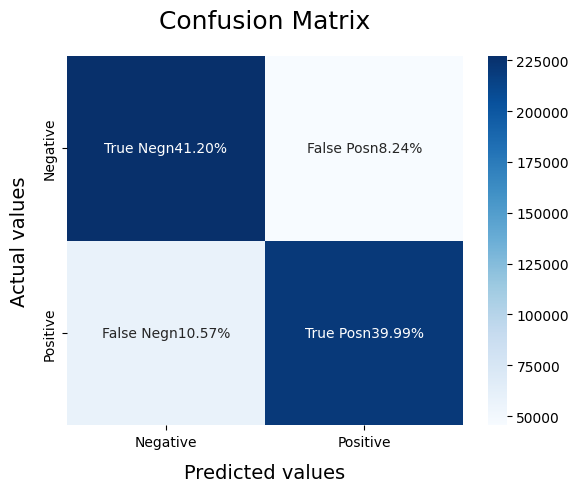

In [22]:
# Print the evaluation metrics for the dataset.

print(classification_report(y_test,bool_array))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test.argmax(axis=1),bool_array.argmax(axis=1))
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)